In [ ]:
''' let's UTTT '''
# v1.1 has bug fixes in the engine
# - _update_board immediately ends the game if finished (possibility of falsely flagging stalemate if the completion of the major square is the last on the board)
# - get_valid_moves now prohibits the ability to place in previously completed major squares
# - draw_board now correctly points to "self"
# - check_validity now checks whether the position is within valid moves # bug allowed non-valid moves to be played (but not displayed with draw_valid_moves()
# - checked default for "silent" # invalid moves now print out the message by default

# added a randomPolicy that plays through a game with random valid moves

In [1]:
''' core imports '''
import numpy as np
np.random.seed(1234)

''' dev imports '''
from time import perf_counter

''' visualize related imports '''
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', ['lightgrey', 'white'])
import matplotlib.colors as mcolors
tab10_names = list(mcolors.TABLEAU_COLORS) # create a list of colours


In [2]:

def checkerboard(shape):
    # from https://stackoverflow.com/questions/2169478/how-to-make-a-checkerboard-in-numpy
    # for visualization
    return np.indices(shape).sum(axis=0) % 2

class uttt_engine():
    def __init__(self):
        self.current_player = 1 # players are "1" and "-1"
        self.active_box = (-1,-1)    # -1 means any box can be active
        self.board_state = np.zeros((9,9))
        self._finished_boxes = np.zeros((3,3)) # -1 and 1 for xs and os. 2 indicates stalemate
        self.finished = False
        self.finished_win = False
        self.finished_stale = False
        self.silent = False
        
    def _check_validity(self, position: tuple) -> bool:
        ''' check whether position - a tuple - is within the valid moves list '''
        temp_moves = self.get_valid_moves()
        return any(np.array([position == x for x in temp_moves]).min(axis=1))
    
    def _check_line(self, box):
        '''
        box is a (3,3) array
        returns True if a line is found
        '''
        for i in range(3):
            if abs(sum(box[:,i])) == 3: return True # horizontal
            if abs(sum(box[i,:])) == 3: return True # vertical

        # diagonals
        if abs(box.trace()) == 3: return True
        if abs(np.rot90(box).trace()) == 3: return True

    def map_to_major(self, position: tuple) -> tuple:
        '''
        converts position to major coordinates
        eg: (5,3) -> (1,1)
        '''
        return(position[0]//3, position[1]//3)

    def map_to_minor(self, position: tuple) -> tuple:
        '''
        converts position into mini coordinates
        eg: (5,3) -> (2,0)
        '''
        return (position[0]%3, position[1]%3)

    def _check_full_stale(self) -> None:
        ''' check whether game is complete by the number of finished boxes '''
        if (self._finished_boxes == 0).sum() == 0:
            self.finished_stale = True
            self.finished = True

    def _update_board(self, position: tuple) -> None:
        '''
        the main game logic. board updates and logic checks.
        '''
        if self.finished:
            print('game finished')
            return
        
        if self._check_validity(position):
            
            # place marker
            self.board_state[position] = self.current_player
            
            # select both scales
            temp_box = self.map_to_major(position)
            temp_minor_box = self.board_state[3*temp_box[0]:3*temp_box[0]+3,
                                              3*temp_box[1]:3*temp_box[1]+3]
            
            ''' check line at minor scale '''
            if self._check_line(temp_minor_box):
                self._finished_boxes[self.map_to_major(position)] = self.current_player
                
                # check line at major scale
                if self._check_line(self._finished_boxes):
                    self.finished_win = True
                    self.finished = True
                    return # immediately end the game

            # if no squares are open, mark as stale
            elif (temp_minor_box == 0).sum() == 0:
                self._finished_boxes[self.map_to_major(position)] = 6 # indicates stalemate in that box
            
            # is the whole game board stale?
            self._check_full_stale()
            
            # calculate active box
            self.active_box = self.map_to_minor(position)
            # if that box is won or stale flag it
            if self._finished_boxes[self.active_box] != 0:
                self.active_box = (-1,-1)
            
            self.current_player *= -1 # switch player

        else:
            if not self.silent:
                print('move invalid, try again')

    def get_valid_moves(self) -> np.array:
        '''
        returns an array (N,2) of valid moves
        '''
        # define masks that cover the board
        # across the whole board
        full_board_mask = (self.board_state == 0)
        # active square
        active_box_mask = np.zeros((9,9),dtype=bool)
        # identifies finished major boxes
        a = np.repeat(self._finished_boxes,3).reshape(3,9)
        b = np.tile(a,3).reshape(9,9)
        finished_box_mask = (b == 0)
        
        if self.active_box == (-1,-1):
            active_box_mask[:] = True
            active_box_mask *= finished_box_mask
        else:
            active_box_mask[3*self.active_box[0]:3*self.active_box[0]+3,
                            3*self.active_box[1]:3*self.active_box[1]+3] = True

        # return get union of maps
        return np.array(np.where(active_box_mask * full_board_mask)).T

    def draw_valid_moves(self) -> None:
        moves = self.get_valid_moves()
        plt.scatter(moves[:,0],moves[:,1],marker='s',c='purple',alpha=0.3, s=50)
        
    def draw_board(self, marker_size: int = 100) -> None:
        plt.imshow(checkerboard((9,9)), cmap=cmap, origin='lower')
        for i in [-0.5,2.5,5.5, 8.5]:
            plt.axvline(i,c='k')
            plt.axhline(i,c='k')
        plt.axis('off')

        plt.scatter(*np.where(self.board_state == -1),marker='x',s=marker_size,c='tab:blue')
        plt.scatter(*np.where(self.board_state == 1), marker='o',s=marker_size,c='tab:orange')
        
        x_boxes = np.where(self._finished_boxes == -1)
        o_boxes = np.where(self._finished_boxes == 1)
        plt.scatter(x_boxes[0]*3+1,x_boxes[1]*3+1,marker='s',s=marker_size*50,alpha=0.6,c='tab:blue')
        plt.scatter(o_boxes[0]*3+1,o_boxes[1]*3+1,marker='s',s=marker_size*50,alpha=0.6,c='tab:orange')
        
        stale_boxes = np.where(self._finished_boxes == 6)
        plt.scatter(stale_boxes[0]*3+1,stale_boxes[1]*3+1,marker='s',s=marker_size*50,alpha=0.3,c='k')
        

In [3]:
def randomPolicy(state):
    '''
    state is the engine
    randomly plays valid move alternating between players
    '''
    while not state.finished:
        # get a random valid move
        valid_moves = state.get_valid_moves()
        random_index = np.random.choice(np.arange(len(valid_moves)))
        # take the random valid move
        pos = tuple(valid_moves[random_index])
        state._update_board(pos)
        
    return state


time: 0.03159605299999946
engine.finished = True
engine.finished_stale = True


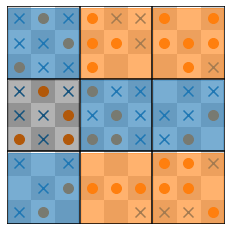

In [4]:
''' look for full game stale mates '''
# there was an couple errors here in the previous version

stale = False
while not stale:
    engine = uttt_engine()
    start = perf_counter()
    engine = randomPolicy(engine)
    if engine.finished_stale:
        stale = True
print('time:', perf_counter()-start) # finishing a random moves takes ~0.02 seconds
engine.draw_board()
print(f'{engine.finished = }')
print(f'{engine.finished_stale = }')


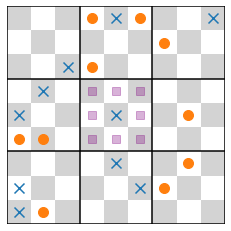

In [5]:
''' demonstrate get_valid_moves() '''
engine = uttt_engine()

for _ in range(20):
    # get list of valid moves
    valid_moves = engine.get_valid_moves()
    # randomly select one (using its index)
    random_index = np.random.choice(np.arange(len(valid_moves)))
    pos = tuple(valid_moves[random_index])
    # play the random move
    engine._update_board(pos)

engine.draw_board()
engine.draw_valid_moves()

move invalid, try again


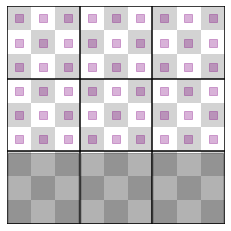

In [6]:
''' dev: bug squashing '''
engine = uttt_engine()
engine._finished_boxes[:,0] = 6 # set bottom row as stalemates
engine.draw_board()
engine.draw_valid_moves()

engine._update_board((0,0)) # try to place an invalid move